In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (VGG16 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG16(weights='imagenet', input_shape=image_shape, include_top=False, pooling=None)

In [7]:
# Adding the top layer
x = Flatten(name='flatten')(base_model.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [9]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-vgg16-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [10]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.0307
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 110s - loss: 11.0185 - acc: 0.3138 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 2/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 3/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 4/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 5/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 6/100
8394/8394 [==============================] - 100s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 7/100
8394/8394 [==============================] - 100s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 8/100
83

8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 64/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 65/100
8394/8394 [==============================] - 103s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 66/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 67/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 68/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 69/100
8394/8394 [==============================] - 101s - loss: 11.0219 - acc: 0.3162 - val_loss: 11.0865 - val_acc: 0.3122
Epoch 70/100
8394/8394 [==============================] - 100s - loss: 11.0219 - acc: 0.3162 - v

8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 25/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 26/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 27/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 28/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 29/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 30/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 31/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss:

8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 88/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 89/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 90/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 91/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 92/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 93/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss: 13.3975 - val_acc: 0.1688
Epoch 94/100
8397/8397 [==============================] - 99s - loss: 13.3694 - acc: 0.1705 - val_loss:

8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 49/100
8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 50/100
8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 51/100
8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 52/100
8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 53/100
8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 54/100
8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss: 11.0490 - val_acc: 0.3145
Epoch 55/100
8401/8401 [==============================] - 99s - loss: 11.0262 - acc: 0.3159 - val_loss:

8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 10/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 11/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 12/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 13/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 14/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 15/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 16/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss:

8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 73/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 74/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 75/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 76/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 77/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 78/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss: 13.3801 - val_acc: 0.1699
Epoch 79/100
8403/8403 [==============================] - 99s - loss: 13.3713 - acc: 0.1704 - val_loss:

8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 34/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 35/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 36/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 37/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 38/100
8404/8404 [==============================] - 98s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 39/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 40/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss:

8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 97/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 98/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 99/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 100/100
928/935 [============================>.] - ETA: 0s[4] Test acurracy: 0.3155 (9935.8041 s)
[5] Initial acurracy: 0.0257
Train on 8404 samples, validate on 935 samples
Epoch 1/100
8404/8404 [==============================] - 99s - loss: 11.1494 - acc: 0.3066 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 2/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 3/100
8404/8404 [==============================] 

8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 58/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 59/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 60/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 61/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 62/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 63/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss: 11.0327 - val_acc: 0.3155
Epoch 64/100
8404/8404 [==============================] - 99s - loss: 11.0280 - acc: 0.3158 - val_loss:

8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 19/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 20/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 21/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 22/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 23/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 24/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 25/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss:

8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 82/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 83/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 84/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 85/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 86/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 87/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss: 13.3654 - val_acc: 0.1708
Epoch 88/100
8408/8408 [==============================] - 99s - loss: 13.3730 - acc: 0.1703 - val_loss:

8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss: 13.3595 - val_acc: 0.1712
Epoch 43/100
8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss: 13.3595 - val_acc: 0.1712
Epoch 44/100
8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss: 13.3595 - val_acc: 0.1712
Epoch 45/100
8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss: 13.3595 - val_acc: 0.1712
Epoch 46/100
8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss: 13.3595 - val_acc: 0.1712
Epoch 47/100
8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss: 13.3595 - val_acc: 0.1712
Epoch 48/100
8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss: 13.3595 - val_acc: 0.1712
Epoch 49/100
8410/8410 [==============================] - 99s - loss: 13.3736 - acc: 0.1703 - val_loss:

8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 4/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 5/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 6/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 7/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 8/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 9/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 10/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.97

8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 67/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 68/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 69/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 70/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 71/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 72/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss: 10.9777 - val_acc: 0.3189
Epoch 73/100
8414/8414 [==============================] - 99s - loss: 11.0340 - acc: 0.3154 - val_loss:

8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 28/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 29/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 30/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 31/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 32/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 33/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 34/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss:

8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 91/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 92/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 93/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 94/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 95/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 96/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss: 10.9841 - val_acc: 0.3185
Epoch 97/100
8416/8416 [==============================] - 99s - loss: 11.0333 - acc: 0.3155 - val_loss:

In [11]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.2575


In [12]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

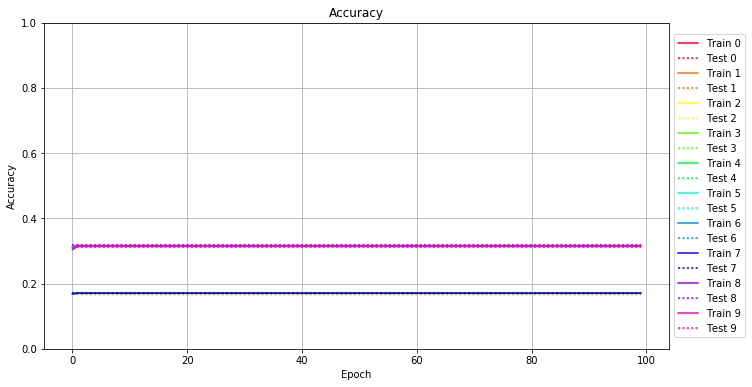

In [13]:
plot_acc(history)

In [14]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

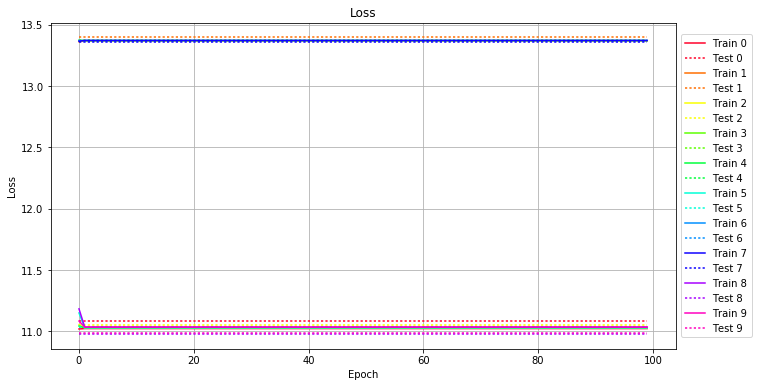

In [15]:
plot_loss(history)

Plotting the confusion matrix


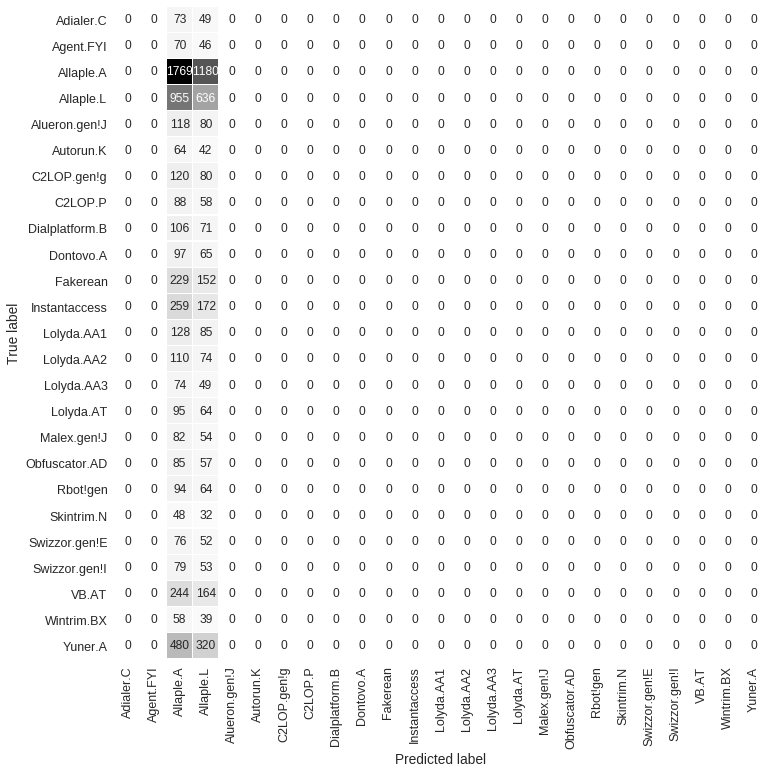

In [16]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


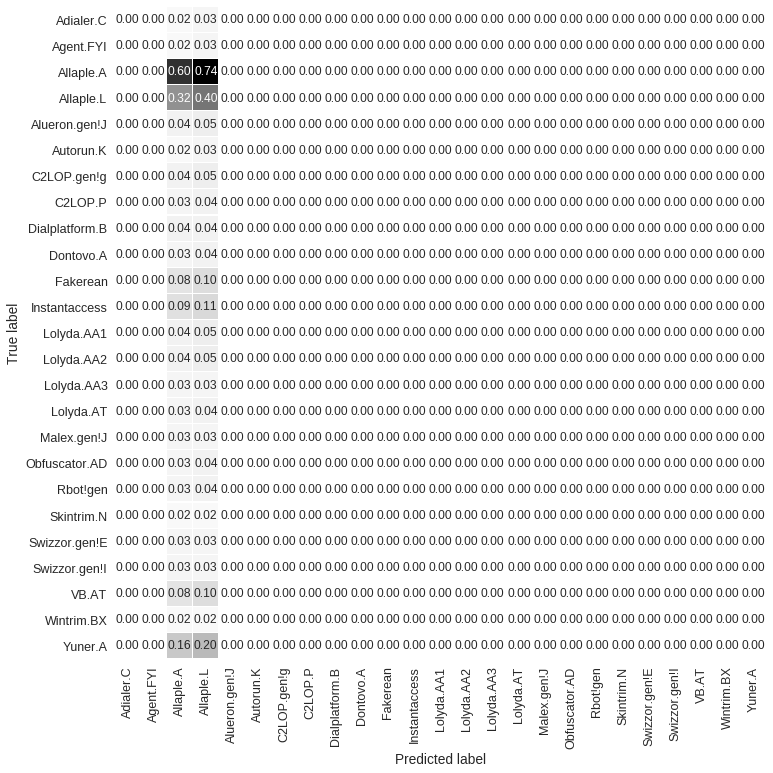

In [17]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [18]:
for h in history:
    print(h.history)

{'acc': [0.31379556827014587, 0.31617822253990946, 0.31617822254701033, 0.31617822254168465, 0.31617822254701033, 0.3161782225434599, 0.31617822256831291, 0.3161782225434599, 0.31617822254701033, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822255411121, 0.3161782225434599, 0.3161782225434599, 0.3161782225434599, 0.3161782225434599, 0.3161782225434599, 0.31617822255411121, 0.31617822255411121, 0.31617822254168465, 0.31617822253990946, 0.31617822254701033, 0.3161782225434599, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822254701033, 0.31617822255411121, 0.31617822256831291, 0.31617822254168465, 0.31617822254701033, 0.31617822259671635, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822255411121, 0.31617822254701033, 0.3161782225434599, 0.31617822253990946, 0.31617822255411121, 0.31617822254701033, 0.31617822253990946, 0.31617822255411121, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822255411

In [19]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

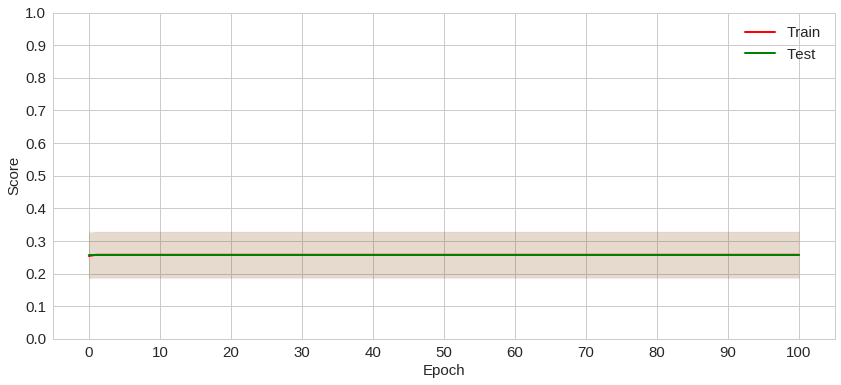

In [20]:
plot_mean_acc(history)

In [21]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

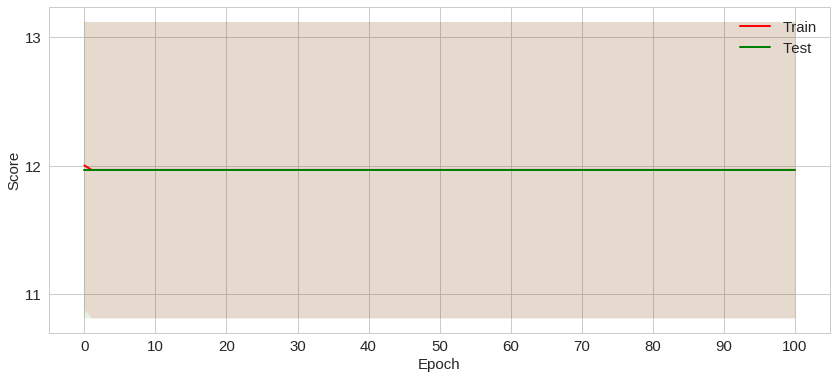

In [22]:
plot_mean_loss(history)

In [24]:
hist = [{'acc': [0.31379556827014587, 0.31617822253990946, 0.31617822254701033, 0.31617822254168465, 0.31617822254701033, 0.3161782225434599, 0.31617822256831291, 0.3161782225434599, 0.31617822254701033, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822255411121, 0.3161782225434599, 0.3161782225434599, 0.3161782225434599, 0.3161782225434599, 0.3161782225434599, 0.31617822255411121, 0.31617822255411121, 0.31617822254168465, 0.31617822253990946, 0.31617822254701033, 0.3161782225434599, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822254701033, 0.31617822255411121, 0.31617822256831291, 0.31617822254168465, 0.31617822254701033, 0.31617822259671635, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822255411121, 0.31617822254701033, 0.3161782225434599, 0.31617822253990946, 0.31617822255411121, 0.31617822254701033, 0.31617822253990946, 0.31617822255411121, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822255411121, 0.31617822259671635, 0.31617822254701033, 0.31617822254168465, 0.31617822254701033, 0.31617822255411121, 0.3161782225434599, 0.3161782225434599, 0.31617822256831291, 0.3161782225434599, 0.31617822253990946, 0.31617822254168465, 0.31617822255411121, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822255411121, 0.31617822254701033, 0.31617822255411121, 0.31617822253990946, 0.31617822255411121, 0.31617822255411121, 0.3161782225434599, 0.31617822254701033, 0.3161782225434599, 0.3161782225434599, 0.31617822255411121, 0.31617822255411121, 0.31617822254701033, 0.3161782225434599, 0.3161782225434599, 0.31617822253990946, 0.31617822254168465, 0.31617822256831291, 0.31617822254168465, 0.31617822254701033, 0.31617822254701033, 0.31617822253990946, 0.3161782225434599, 0.3161782225434599, 0.31617822255411121, 0.31617822259671635, 0.3161782225434599, 0.3161782225434599, 0.31617822254168465, 0.31617822253990946, 0.31617822255411121, 0.31617822253990946, 0.31617822253990946, 0.31617822255411121, 0.31617822255411121, 0.31617822254168465, 0.31617822255411121], 'loss': [11.018506110097954, 11.021904599760326, 11.021904620892496, 11.021904567948461, 11.021904624528137, 11.021904612257845, 11.021904695536769, 11.021904626800413, 11.021904606349928, 11.0219046711098, 11.021904627482096, 11.021904619529129, 11.021904656567232, 11.021904618392991, 11.021904604986561, 11.021904575901427, 11.021904545680153, 11.021904662020695, 11.021904678381082, 11.0219046711098, 11.021904618847447, 11.021904592489044, 11.021904599078644, 11.021904604986561, 11.02190463475338, 11.021904642024664, 11.021904647478127, 11.021904620892496, 11.021904605668245, 11.021904666451633, 11.021904589762311, 11.021904569993509, 11.021904572606626, 11.021904598396961, 11.021904620210812, 11.021904589307857, 11.021904620210812, 11.021904599078644, 11.021904611121707, 11.021904563403908, 11.021904627482096, 11.021904548179657, 11.021904614302894, 11.021904649295948, 11.021904642024664, 11.02190459180736, 11.02190463475338, 11.021904612939529, 11.021904623505613, 11.021904642706346, 11.021904567948461, 11.021904569993509, 11.021904620210812, 11.02190461475735, 11.021904523866302, 11.021904615552646, 11.021904604986561, 11.021904602487059, 11.021904589762311, 11.021904569311825, 11.021904591125677, 11.021904587490036, 11.021904554087575, 11.021904562040541, 11.02190462816378, 11.021904605668245, 11.021904609758343, 11.021904620210812, 11.0219046711098, 11.021904611121707, 11.021904599078644, 11.021904626800413, 11.021904670428116, 11.021904649295948, 11.02190463475338, 11.02190462816378, 11.021904611121707, 11.021904604986561, 11.021904614302894, 11.021904611576163, 11.021904593738794, 11.021904655203866, 11.021904635435064, 11.021904584536076, 11.021904660657329, 11.021904626800413, 11.021904604986561, 11.021904554769259, 11.021904623505613, 11.021904597715277, 11.021904596579141, 11.021904684289002, 11.021904657930598, 11.021904678381082, 11.021904609758343, 11.021904650659314, 11.021904591125677, 11.021904602032603, 11.021904611576163, 11.021904627482096], 'val_acc': [0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215, 0.31216931216931215], 'val_loss': [11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225, 11.086520684459225]},
{'acc': [0.16934619509451188, 0.17053709660695679, 0.17053709658211266, 0.17053709659098557, 0.17053709660695679, 0.17053709658654911, 0.17053709660695679, 0.17053709659098557, 0.17053709658654911, 0.17053709660695679, 0.17053709659098557, 0.17053709660695679, 0.17053709659098557, 0.17053709659098557, 0.17053709659098557, 0.17053709659985847, 0.17053709659098557, 0.17053709659985847, 0.17053709660695679, 0.17053709658211266, 0.17053709658211266, 0.17053709660695679, 0.17053709658654911, 0.17053709659985847, 0.17053709659098557, 0.17053709660695679, 0.17053709660695679, 0.17053709658654911, 0.17053709659985847, 0.17053709659985847, 0.17053709659098557, 0.17053709658211266, 0.17053709658654911, 0.17053709660695679, 0.17053709660695679, 0.17053709660695679, 0.17053709660695679, 0.17053709658654911, 0.17053709658654911, 0.17053709660695679, 0.17053709658654911, 0.17053709659985847, 0.17053709659098557, 0.17053709658211266, 0.17053709659098557, 0.17053709660695679, 0.17053709659098557, 0.17053709658211266, 0.17053709660695679, 0.17053709658654911, 0.17053709658211266, 0.17053709659098557, 0.17053709658211266, 0.17053709659985847, 0.17053709659985847, 0.17053709658654911, 0.17053709659098557, 0.17053709659098557, 0.17053709660695679, 0.17053709663889927, 0.17053709659098557, 0.17053709658211266, 0.17053709658654911, 0.17053709658211266, 0.17053709659098557, 0.17053709658654911, 0.17053709660695679, 0.17053709660695679, 0.17053709658211266, 0.17053709659985847, 0.17053709659098557, 0.17053709659098557, 0.17053709660695679, 0.17053709658654911, 0.17053709658211266, 0.17053709659985847, 0.17053709660695679, 0.17053709660695679, 0.17053709658654911, 0.17053709660695679, 0.17053709659098557, 0.17053709658211266, 0.17053709659098557, 0.17053709659098557, 0.17053709659098557, 0.17053709659985847, 0.17053709659098557, 0.17053709659098557, 0.17053709660695679, 0.17053709659098557, 0.17053709659098557, 0.17053709659098557, 0.17053709659098557, 0.17053709658654911, 0.17053709663180094, 0.17053709658654911, 0.17053709658654911, 0.17053709660695679, 0.17053709660695679, 0.17053709660695679], 'loss': [13.362220644908277, 13.369362150698571, 13.369362220886819, 13.369362215776025, 13.369362296072289, 13.369362315720457, 13.369362245191487, 13.369362193969966, 13.369362273584793, 13.36936236875915, 13.369362257911689, 13.369362237922802, 13.369362281194197, 13.369362273925512, 13.369362221568258, 13.369362297889461, 13.369362266656827, 13.369362239739974, 13.369362237922802, 13.369362249961563, 13.369362271767621, 13.369362230654117, 13.369362264839655, 13.369362290620776, 13.369362281194197, 13.36936222338543, 13.369362325147033, 13.369362279377027, 13.369362239739974, 13.369362232471287, 13.369362281194197, 13.369362249961563, 13.369362259047421, 13.369362237922802, 13.369362281534919, 13.369362259728859, 13.369362245191487, 13.369362243033597, 13.369362322989144, 13.369362317878348, 13.369362259047421, 13.369362283352089, 13.369362257911689, 13.369362235424191, 13.369362214299572, 13.369362288803604, 13.369362281194197, 13.36936229357368, 13.369362288803604, 13.369362251778735, 13.369362308111052, 13.369362272449061, 13.36936229357368, 13.369362348770263, 13.369362290620776, 13.369362264839655, 13.369362317537629, 13.369362281194197, 13.369362194310686, 13.369362225543322, 13.369362266656827, 13.369362264498935, 13.369362244510048, 13.369362286304993, 13.36936223610563, 13.369362309928222, 13.369362216116745, 13.369362310609661, 13.369362242692878, 13.369362290620776, 13.369362208507338, 13.36936222304471, 13.36936222338543, 13.369362288122165, 13.36936229357368, 13.369362348770263, 13.369362310609661, 13.369362245191487, 13.369362315720457, 13.369362303340976, 13.369362310268942, 13.369362300842365, 13.369362266656827, 13.36936222304471, 13.369362273925512, 13.369362254277345, 13.369362250643002, 13.369362252119455, 13.369362288803604, 13.36936225938814, 13.369362266656827, 13.369362230313396, 13.369362286986432, 13.36936229539085, 13.369362254958785, 13.36936223576491, 13.369362228496225, 13.369362274266232, 13.369362288803604, 13.369362317878348], 'val_acc': [0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744, 0.16878980891719744], 'val_loss': [13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647, 13.397525179917647]},
{'acc': [0.31258183551351165, 0.31591477207577862, 0.31591477206868368, 0.31591477205272006, 0.31591477206158874, 0.31591477205272006, 0.31591477207577862, 0.31591477211480085, 0.31591477207577862, 0.31591477207577862, 0.31591477205449381, 0.31591477205272006, 0.31591477205138974, 0.31591477205183316, 0.31591477206868368, 0.31591477206868368, 0.31591477207577862, 0.31591477207577862, 0.31591477207577862, 0.31591477206868368, 0.31591477207577862, 0.315914772059815, 0.31591477206158874, 0.31591477205272006, 0.31591477206868368, 0.31591477205272006, 0.31591477207577862, 0.31591477206158874, 0.31591477205272006, 0.31591477210770591, 0.31591477210770591, 0.31591477207577862, 0.31591477206868368, 0.31591477211480085, 0.31591477207577862, 0.31591477210770591, 0.31591477205272006, 0.31591477206868368, 0.31591477206868368, 0.31591477211480085, 0.31591477206158874, 0.31591477207577862, 0.31591477205272006, 0.31591477207577862, 0.31591477206868368, 0.31591477205183316, 0.31591477210061092, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.31591477205272006, 0.31591477211480085, 0.31591477206158874, 0.31591477209351598, 0.31591477206868368, 0.315914772059815, 0.31591477210061092, 0.31591477210770591, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.315914772059815, 0.31591477205272006, 0.31591477206868368, 0.31591477205183316, 0.31591477205272006, 0.31591477207577862, 0.31591477207577862, 0.31591477207577862, 0.31591477206158874, 0.31591477206868368, 0.315914772059815, 0.31591477207577862, 0.31591477211480085, 0.31591477206868368, 0.31591477205138974, 0.31591477207577862, 0.315914772059815, 0.31591477206868368, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.31591477206868368, 0.31591477210770591, 0.31591477206868368, 0.315914772059815, 0.31591477206868368, 0.31591477207577862, 0.315914772059815, 0.31591477207577862, 0.31591477206158874, 0.31591477207577862, 0.31591477206868368, 0.31591477205272006, 0.31591477205272006, 0.31591477206158874, 0.31591477206868368, 0.31591477206158874, 0.31591477209351598, 0.31591477206868368], 'loss': [11.052967207756174, 11.026150920819333, 11.026150949426158, 11.02615092660881, 11.026150907310555, 11.026150890282684, 11.026150935349785, 11.026150930581981, 11.026150920819333, 11.026150993471585, 11.026150966908105, 11.02615095566971, 11.026150938641839, 11.026150925587137, 11.026150891304356, 11.026150913100032, 11.026150957145459, 11.026150891758434, 11.026150906288883, 11.026150913100032, 11.026150942615009, 11.026150939663511, 11.026150929106231, 11.026150948404485, 11.026150931263095, 11.026150962934935, 11.026150906288883, 11.026150950901906, 11.026150984730611, 11.026150931092817, 11.026150931092817, 11.02615100073681, 11.026150920365257, 11.026150966908105, 11.026150949880234, 11.026150960153716, 11.026150904813134, 11.026150949426158, 11.026150905834808, 11.026150930581981, 11.026150936371456, 11.026150935349785, 11.026150912078359, 11.026150906288883, 11.026150876773906, 11.026150925587137, 11.026150953399327, 11.026150905834808, 11.026150971221833, 11.026150932398286, 11.02615092660881, 11.026150937847206, 11.026150958167131, 11.026150994833815, 11.026150927630482, 11.026150932398286, 11.026150909807978, 11.026150876603628, 11.026150927630482, 11.026150925133061, 11.026150963956608, 11.026150903337387, 11.026150991995836, 11.026150905834808, 11.026150969178488, 11.026150948404485, 11.026150891758434, 11.026150978941134, 11.026150906288883, 11.026150936371456, 11.026150891304356, 11.026150990520087, 11.02615098620636, 11.026150930581981, 11.026150942160932, 11.026150953172289, 11.026150993471585, 11.026150932398286, 11.026151007547959, 11.026150898569583, 11.026150903337387, 11.026150920365257, 11.026151000282734, 11.026150923827592, 11.026150934895707, 11.026150946928736, 11.02615084044778, 11.026150978941134, 11.02615089607216, 11.026150906288883, 11.026150936371456, 11.026150877227982, 11.026150949426158, 11.026150853956558, 11.026150912078359, 11.026150907310555, 11.026150884039131, 11.026150929106231, 11.026150962140301, 11.026150884039131], 'val_acc': [0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896, 0.31449893390191896], 'val_loss': [11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498, 11.048971611299498]},
{'acc': [0.16851124598535061, 0.17041532788037772, 0.17041532784491142, 0.17041532786264457, 0.17041532786264457, 0.17041532784491142, 0.17041532784491142, 0.17041532786087127, 0.17041532784491142, 0.17041532785998459, 0.17041532786087127, 0.17041532786264457, 0.17041532785998459, 0.17041532783072491, 0.17041532784491142, 0.17041532783072491, 0.17041532788037772, 0.17041532788037772, 0.17041532786264457, 0.17041532791584399, 0.17041532784491142, 0.17041532785998459, 0.17041532784845806, 0.17041532784491142, 0.17041532785909794, 0.17041532784491142, 0.17041532785998459, 0.17041532784491142, 0.17041532784491142, 0.17041532784491142, 0.17041532785998459, 0.17041532788037772, 0.17041532785998459, 0.17041532784845806, 0.17041532785998459, 0.17041532784491142, 0.17041532784491142, 0.17041532784845806, 0.17041532786264457, 0.17041532788037772, 0.17041532784491142, 0.17041532785998459, 0.17041532784491142, 0.17041532785998459, 0.17041532784491142, 0.17041532786264457, 0.17041532786264457, 0.17041532786264457, 0.17041532786087127, 0.17041532784491142, 0.17041532786087127, 0.17041532786087127, 0.17041532788037772, 0.17041532784845806, 0.17041532786264457, 0.17041532785909794, 0.17041532786264457, 0.17041532788037772, 0.17041532786264457, 0.17041532788037772, 0.17041532786264457, 0.17041532786087127, 0.17041532783072491, 0.17041532789811087, 0.17041532786264457, 0.17041532785998459, 0.17041532786087127, 0.17041532786087127, 0.17041532786264457, 0.17041532784491142, 0.17041532786264457, 0.17041532786264457, 0.17041532788037772, 0.17041532783072491, 0.17041532785909794, 0.17041532786087127, 0.17041532786087127, 0.17041532786264457, 0.17041532784491142, 0.17041532788037772, 0.17041532786087127, 0.17041532786264457, 0.17041532786087127, 0.17041532786087127, 0.17041532785998459, 0.17041532786087127, 0.17041532786264457, 0.17041532786087127, 0.17041532786264457, 0.17041532786087127, 0.17041532788037772, 0.17041532785998459, 0.17041532784491142, 0.17041532785998459, 0.17041532788037772, 0.17041532784491142, 0.17041532788037772, 0.17041532786087127, 0.17041532786087127, 0.17041532784845806], 'loss': [13.374595857497894, 13.371324927554618, 13.371324911892705, 13.371324985095125, 13.371325019256254, 13.371324926419696, 13.371324938790337, 13.371324938222878, 13.371324970000673, 13.371325010290377, 13.37132488011491, 13.371324953884791, 13.371324937655418, 13.37132497896655, 13.371324960580827, 13.371324906331591, 13.371324978399089, 13.371324920291123, 13.371324992358621, 13.37132496500702, 13.371324933683193, 13.37132491586493, 13.371324921426043, 13.371324926419696, 13.371324958878445, 13.37132491699985, 13.37132491586493, 13.371324904629208, 13.371324897365714, 13.37132495331733, 13.371324930391921, 13.37132494208161, 13.371324986343538, 13.371324972270514, 13.371325022661019, 13.371324938790337, 13.371324991791161, 13.371324972270514, 13.37132499020227, 13.37132490576413, 13.371324977264168, 13.371324937655418, 13.371324911892705, 13.371325003026881, 13.37132486831173, 13.371324970568132, 13.371324844932351, 13.371324932094304, 13.371324916432389, 13.371324940946689, 13.37132495274987, 13.371324909168894, 13.371324949345105, 13.371324906899051, 13.371324934250653, 13.371324900770476, 13.371324881249832, 13.371324913027626, 13.371324968411782, 13.371324862183155, 13.371324975675279, 13.371324967276861, 13.371324928122078, 13.371324969546704, 13.371324975675279, 13.371324920972075, 13.371325018121333, 13.371324967276861, 13.371324881249832, 13.371324880682371, 13.371324939357798, 13.371324970568132, 13.371325000189577, 13.371324971703054, 13.371324980668932, 13.371324945486373, 13.371324930959382, 13.371324919723662, 13.371324933683193, 13.371324971135593, 13.371324967276861, 13.371324912460166, 13.371325003594341, 13.371324981803854, 13.371324908601434, 13.371324938222878, 13.37132499020227, 13.371324829270439, 13.371324939357798, 13.371324930959382, 13.371325007453073, 13.371324935499066, 13.371324931526843, 13.371324937655418, 13.371325000189577, 13.371324991791161, 13.371324949345105, 13.37132488011491, 13.371324981803854, 13.371324870581573], 'val_acc': [0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488, 0.16987179487179488], 'val_loss': [13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957, 13.380085627237957]},
{'acc': [0.31354117088519862, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199910481166, 0.31580199905516476, 0.31580199904807232, 0.31580199904807232, 0.3158019990338875, 0.3158019990622572, 0.3158019990622572, 0.31580199901970268, 0.31580199904807232, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199907644202, 0.3158019990338875, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.31580199909062684, 0.31580199905516476, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.3158019991331813, 0.31580199907644202, 0.31580199904807232, 0.3158019990338875, 0.31580199905516476, 0.31580199910481166, 0.31580199901970268, 0.3158019990338875, 0.31580199905516476, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199910481166, 0.31580199904807232, 0.31580199905516476, 0.31580199905161854, 0.31580199905516476, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.3158019990622572, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.31580199910481166, 0.3158019990622572, 0.31580199905516476, 0.3158019990622572, 0.31580199909062684, 0.31580199907644202, 0.31580199910481166, 0.3158019990622572, 0.3158019990622572, 0.31580199901970268, 0.31580199905516476, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.3158019990338875, 0.3158019990338875, 0.31580199910481166, 0.3158019990622572, 0.31580199910481166, 0.3158019990622572, 0.31580199901970268, 0.31580199907644202, 0.31580199910481166, 0.31580199909062684, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.31580199904807232, 0.31580199910481166], 'loss': [11.042443306317844, 11.027968592328268, 11.027968605945702, 11.027968642258859, 11.027968593236096, 11.027968664046755, 11.027968638627543, 11.027968676756361, 11.027968685834649, 11.027968627733596, 11.027968616839649, 11.027968581434319, 11.027968691735538, 11.027968615931821, 11.027968664046755, 11.027968614570076, 11.027968595959583, 11.027968607761359, 11.027968607761359, 11.027968527872412, 11.027968588696952, 11.027968649521492, 11.027968644074518, 11.027968647705833, 11.027968571448202, 11.027968674940702, 11.027968569632543, 11.027968667678071, 11.027968585973465, 11.027968617747478, 11.027968603676129, 11.027968620924879, 11.02796862818751, 11.027968633180571, 11.027968601860472, 11.027968671309386, 11.027968650429321, 11.027968547844649, 11.027968630910998, 11.027968659961525, 11.027968687650308, 11.027968627733596, 11.02796858052649, 11.027968669493728, 11.027968616839649, 11.027968703083399, 11.027968658145866, 11.027968633180571, 11.027968627733596, 11.027968601860472, 11.027968663592841, 11.027968578710833, 11.027968584157806, 11.027968680387676, 11.027968671309386, 11.027968593236096, 11.027968598683071, 11.027968609577018, 11.027968576895175, 11.027968635450142, 11.027968619563136, 11.027968618655306, 11.027968629549255, 11.027968570994286, 11.027968566001228, 11.027968667224156, 11.027968626825768, 11.027968674940702, 11.027968599590899, 11.027968682203333, 11.027968599590899, 11.027968635450142, 11.027968648159748, 11.027968603676129, 11.027968578710833, 11.027968616839649, 11.027968643166689, 11.027968652698892, 11.027968652244978, 11.027968620924879, 11.027968620470965, 11.027968687650308, 11.027968582342149, 11.027968611392675, 11.027968587335208, 11.027968625464023, 11.027968616839649, 11.027968689465965, 11.027968611846589, 11.027968653152808, 11.027968604583958, 11.027968644982346, 11.027968636811886, 11.027968558738596, 11.027968632726656, 11.027968639535374, 11.027968622286624, 11.02796865859978, 11.027968719424321, 11.027968602314386], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.30663969539733571, 0.31580199909062684, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199905516476, 0.3158019990622572, 0.31580199907644202, 0.3158019990622572, 0.3158019990338875, 0.3158019990622572, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199907644202, 0.3158019990622572, 0.31580199910481166, 0.31580199905516476, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.3158019990622572, 0.3158019990622572, 0.31580199907644202, 0.31580199909062684, 0.3158019990338875, 0.31580199904807232, 0.31580199904807232, 0.31580199910481166, 0.31580199905516476, 0.3158019990338875, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.3158019990338875, 0.3158019990622572, 0.31580199907644202, 0.31580199905161854, 0.31580199904807232, 0.31580199907644202, 0.31580199904807232, 0.31580199907644202, 0.31580199910481166, 0.31580199910481166, 0.3158019990338875, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199905161854, 0.31580199907644202, 0.3158019990622572, 0.31580199909062684, 0.3158019991331813, 0.31580199904807232, 0.31580199907644202, 0.3158019990622572, 0.31580199901970268, 0.3158019990622572, 0.31580199907644202, 0.31580199905516476, 0.3158019990622572, 0.31580199910481166, 0.31580199899133304, 0.31580199904807232, 0.3158019990622572, 0.31580199905516476, 0.31580199910481166, 0.31580199907644202, 0.3158019990622572, 0.31580199910481166, 0.31580199910481166, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202, 0.3158019990338875, 0.31580199904807232, 0.31580199907644202, 0.31580199901970268, 0.31580199901970268, 0.31580199907644202, 0.3158019990622572, 0.31580199904807232, 0.31580199910481166, 0.31580199907644202, 0.31580199904807232, 0.3158019990622572, 0.31580199904807232, 0.31580199904807232, 0.31580199904807232, 0.31580199907644202], 'loss': [11.149381677971631, 11.027968632726656, 11.027968618655306, 11.027968652698892, 11.027968626825768, 11.027968593236096, 11.027968707622545, 11.027968636811886, 11.027968625917939, 11.027968616385735, 11.027968600498728, 11.027968674486788, 11.027968573263859, 11.027968667224156, 11.027968536496786, 11.027968617747478, 11.027968575533432, 11.027968584157806, 11.027968616385735, 11.027968598683071, 11.027968659961525, 11.027968577349089, 11.027968583249978, 11.02796864543626, 11.027968638627543, 11.02796858461172, 11.027968660415439, 11.027968667678071, 11.027968671309386, 11.027968700359914, 11.027968630910998, 11.027968521971523, 11.027968629549255, 11.027968632726656, 11.027968636357972, 11.027968569632543, 11.027968603222215, 11.027968616839649, 11.027968599136985, 11.027968602314386, 11.027968548752478, 11.02796869309728, 11.027968558738596, 11.027968621832708, 11.027968594597839, 11.027968629549255, 11.027968583249978, 11.027968591420438, 11.02796861502399, 11.027968555107281, 11.027968600498728, 11.027968616839649, 11.027968624102281, 11.027968660415439, 11.02796858052649, 11.027968660415439, 11.027968665862412, 11.027968619563136, 11.027968644074518, 11.027968674486788, 11.027968596413498, 11.027968638173629, 11.027968642258859, 11.027968636811886, 11.027968652698892, 11.027968652244978, 11.027968616385735, 11.027968673125045, 11.027968610030932, 11.027968621378793, 11.027968602314386, 11.027968613662248, 11.027968634996228, 11.027968640897116, 11.027968602768301, 11.027968558738596, 11.027968636811886, 11.027968638173629, 11.027968551475965, 11.027968616839649, 11.027968642258859, 11.027968664046755, 11.027968613208333, 11.027968702175571, 11.027968551475965, 11.027968613208333, 11.027968625917939, 11.027968615931821, 11.027968623194452, 11.027968564185569, 11.027968669947644, 11.027968642258859, 11.027968674940702, 11.027968702175571, 11.027968627733596, 11.027968640897116, 11.027968634996228, 11.027968639535374, 11.027968562369912, 11.027968680387676], 'val_acc': [0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432, 0.31550802139037432], 'val_loss': [11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087, 11.032707043000087]},
{'acc': [0.16888677452883188, 0.17031398665099684, 0.17031398667935299, 0.17031398670770914, 0.17031398667935299, 0.17031398669353107, 0.17031398669353107, 0.17031398670770914, 0.17031398667935299, 0.17031398669353107, 0.17031398670770914, 0.17031398667935299, 0.17031398668644204, 0.17031398668644204, 0.17031398669353107, 0.17031398667935299, 0.17031398670770914, 0.17031398667935299, 0.17031398667935299, 0.17031398670770914, 0.17031398668644204, 0.17031398667935299, 0.17031398670770914, 0.17031398673606532, 0.17031398670770914, 0.17031398667935299, 0.17031398667935299, 0.17031398670770914, 0.17031398668289752, 0.17031398668644204, 0.17031398668289752, 0.17031398669353107, 0.17031398669353107, 0.17031398667935299, 0.17031398670770914, 0.17031398668289752, 0.17031398669353107, 0.17031398669353107, 0.17031398667935299, 0.17031398670770914, 0.17031398668644204, 0.17031398670770914, 0.17031398667935299, 0.17031398673606532, 0.17031398669353107, 0.17031398667935299, 0.17031398667935299, 0.17031398667935299, 0.17031398667935299, 0.17031398669353107, 0.17031398668644204, 0.17031398668644204, 0.17031398667935299, 0.17031398667935299, 0.17031398668644204, 0.17031398669353107, 0.17031398669353107, 0.17031398669353107, 0.17031398667935299, 0.17031398670770914, 0.17031398670770914, 0.17031398668644204, 0.17031398667935299, 0.17031398667935299, 0.17031398667935299, 0.17031398667935299, 0.17031398668644204, 0.17031398670770914, 0.17031398673606532, 0.17031398669353107, 0.17031398667935299, 0.17031398667935299, 0.17031398670770914, 0.17031398667935299, 0.17031398667935299, 0.17031398670770914, 0.17031398669353107, 0.17031398668289752, 0.17031398670770914, 0.17031398669353107, 0.17031398667935299, 0.17031398665099684, 0.17031398669353107, 0.17031398670770914, 0.17031398667935299, 0.17031398670770914, 0.17031398668644204, 0.17031398670770914, 0.17031398669353107, 0.17031398670770914, 0.17031398667935299, 0.17031398667935299, 0.17031398668289752, 0.17031398670770914, 0.17031398667935299, 0.17031398669353107, 0.17031398667935299, 0.17031398670770914, 0.17031398669353107, 0.17031398670770914], 'loss': [13.373747519829747, 13.372958327564708, 13.372958340268267, 13.372958290361428, 13.372958282194855, 13.372958397434282, 13.372958252250751, 13.372958418304414, 13.37295835478662, 13.372958390175105, 13.372958360231003, 13.37295830850937, 13.372958360231003, 13.372958323935119, 13.372958368397576, 13.372958369304973, 13.372958396526885, 13.372958405600855, 13.372958362045797, 13.372958355694017, 13.372958396526885, 13.372958427378386, 13.372958374749356, 13.372958429193179, 13.372958367490179, 13.372958391082502, 13.372958391082502, 13.372958411045238, 13.372958401971268, 13.372958352971825, 13.372958387452915, 13.372958375656752, 13.372958397434282, 13.372958340268267, 13.372958384730723, 13.372958394712091, 13.372958346620045, 13.372958324842516, 13.372958347527444, 13.372958323935119, 13.372958382008532, 13.372958365675384, 13.372958360231003, 13.372958371119767, 13.372958419211811, 13.372958434637562, 13.372958381101135, 13.372958369304973, 13.372958347527444, 13.372958390175105, 13.372958374749356, 13.372958352971825, 13.372958402878664, 13.372958347527444, 13.372958367490179, 13.372958382915929, 13.372958382915929, 13.372958390175105, 13.372958412860031, 13.372958348434841, 13.372958309416767, 13.372958331194296, 13.372958347527444, 13.372958362045797, 13.372958376564149, 13.372958347527444, 13.372958345712648, 13.372958396526885, 13.37295836386059, 13.372958368397576, 13.372958340268267, 13.372958369304973, 13.37295842556359, 13.372958383823326, 13.372958362045797, 13.372958423748797, 13.372958353879223, 13.372958394712091, 13.372958403786061, 13.372958346620045, 13.372958391082502, 13.37295840741565, 13.372958404693458, 13.372958362953193, 13.372958376564149, 13.372958345712648, 13.372958331194296, 13.372958319398133, 13.372958339360869, 13.372958352971825, 13.372958470933444, 13.372958362045797, 13.372958322120326, 13.372958384730723, 13.372958347527444, 13.372958339360869, 13.37295835478662, 13.372958447341121, 13.37295831758334, 13.372958314861149], 'val_acc': [0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017, 0.17078410311493017], 'val_loss': [13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095, 13.365380956074095]},
{'acc': [0.16884661123386888, 0.17027348399020545, 0.17027348395211092, 0.17027348396539971, 0.17027348395654052, 0.17027348399020545, 0.17027348397248707, 0.17027348400438017, 0.17027348396539971, 0.17027348396539971, 0.17027348396185604, 0.17027348396539971, 0.17027348396539971, 0.17027348399020545, 0.17027348399020545, 0.17027348397248707, 0.17027348399020545, 0.17027348395122502, 0.17027348399020545, 0.17027348395654052, 0.17027348399729281, 0.17027348399729281, 0.17027348395211092, 0.17027348400438017, 0.17027348399729281, 0.17027348400438017, 0.17027348396539971, 0.17027348396539971, 0.17027348396539971, 0.17027348396539971, 0.17027348397248707, 0.17027348395831235, 0.17027348395654052, 0.17027348395831235, 0.17027348397603076, 0.17027348397248707, 0.17027348397248707, 0.17027348399729281, 0.17027348395831235, 0.17027348397248707, 0.17027348395831235, 0.17027348400438017, 0.17027348399729281, 0.17027348395654052, 0.17027348397248707, 0.17027348399729281, 0.17027348395654052, 0.17027348399729281, 0.17027348399020545, 0.17027348395654052, 0.17027348399729281, 0.17027348397248707, 0.17027348399020545, 0.17027348398311809, 0.17027348396539971, 0.17027348399729281, 0.17027348399729281, 0.17027348397248707, 0.17027348400438017, 0.17027348396539971, 0.17027348396539971, 0.17027348399020545, 0.17027348399729281, 0.17027348394768133, 0.17027348395654052, 0.17027348399729281, 0.17027348395122502, 0.17027348396539971, 0.17027348395211092, 0.17027348400438017, 0.17027348399020545, 0.17027348399729281, 0.17027348399020545, 0.17027348399020545, 0.17027348396539971, 0.17027348395654052, 0.17027348397248707, 0.17027348399020545, 0.17027348396539971, 0.17027348395831235, 0.17027348407525369, 0.17027348397248707, 0.17027348395654052, 0.17027348399729281, 0.17027348396539971, 0.17027348400438017, 0.17027348397603076, 0.17027348396539971, 0.17027348399729281, 0.17027348407525369, 0.17027348396539971, 0.17027348395654052, 0.17027348395654052, 0.17027348396539971, 0.17027348399729281, 0.17027348399020545, 0.17027348400438017, 0.17027348395831235, 0.17027348396539971, 0.17027348397248707], 'loss': [13.367035261827757, 13.373611161258076, 13.373611156268579, 13.373611202308028, 13.373611191421853, 13.373611241090028, 13.373611196184555, 13.373611121342099, 13.373611245852731, 13.373611170329889, 13.373611126331596, 13.373611151505877, 13.373611195050579, 13.373611183030427, 13.373611197545328, 13.373611204802778, 13.373611241090028, 13.373611115899012, 13.373611233832579, 13.373611216142542, 13.373611202988414, 13.373611159443714, 13.37361121432818, 13.373611179401701, 13.373611188473514, 13.373611135857001, 13.373611129733527, 13.37361121387459, 13.37361121682293, 13.373611173278228, 13.373611181669656, 13.373611189607491, 13.373611230657444, 13.373611189607491, 13.373611208431502, 13.373611178721315, 13.373611159897305, 13.373611224760765, 13.373611225894741, 13.373611207751116, 13.373611196864941, 13.373611201174052, 13.373611130413913, 13.373611136310592, 13.373611181669656, 13.373611239275666, 13.373611208885093, 13.373611210245866, 13.373611226575129, 13.373611184164403, 13.373611232018215, 13.373611210699456, 13.373611183030427, 13.373611184844789, 13.373611112270288, 13.373611246533116, 13.373611181216065, 13.373611207751116, 13.373611208431502, 13.373611170329889, 13.373611231337829, 13.373611146743176, 13.373611217503315, 13.373611241543619, 13.373611259687245, 13.373611202988414, 13.373611173958613, 13.373611202308028, 13.373611141753679, 13.373611201174052, 13.373611154000626, 13.373611195730964, 13.373611161258076, 13.373611233832579, 13.373611163072439, 13.373611230657444, 13.373611178721315, 13.373611212060228, 13.373611231337829, 13.37361116057769, 13.373611235646941, 13.373611200493666, 13.37361112179569, 13.373611181216065, 13.373611202308028, 13.373611281006005, 13.373611193916602, 13.373611180535677, 13.373611202988414, 13.373611235646941, 13.37361121387459, 13.373611140619703, 13.373611288717045, 13.373611195050579, 13.373611195730964, 13.373611110455924, 13.373611208431502, 13.373611240409643, 13.373611180535677, 13.373611142434065], 'val_acc': [0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693, 0.17115177610333693], 'val_loss': [13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634, 13.359454767824634]},
{'acc': [0.30449251262088101, 0.31542666989265949, 0.31542666988557555, 0.31542666989974349, 0.31542666997766733, 0.31542666997766733, 0.31542666987849155, 0.31542666999183527, 0.31542666987849155, 0.31542666989265949, 0.31542666990682749, 0.31542666996349938, 0.31542666988557555, 0.31542666996349938, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666989265949, 0.31542666986432355, 0.31542666988557555, 0.31542666997766733, 0.31542666995641538, 0.31542666986432355, 0.31542666997766733, 0.31542666988557555, 0.31542666995641538, 0.31542666986078161, 0.31542666996349938, 0.31542667006267516, 0.31542666997766733, 0.31542666996349938, 0.31542666983598766, 0.31542666997058333, 0.31542666994933138, 0.31542666997766733, 0.31542666996349938, 0.31542666989974349, 0.31542666996349938, 0.31542666997766733, 0.31542666996349938, 0.31542666988557555, 0.31542666987849155, 0.31542666995641538, 0.31542666987849155, 0.31542666990682749, 0.31542666999183527, 0.31542666987849155, 0.31542666996349938, 0.31542666999183527, 0.31542666997766733, 0.31542666997766733, 0.31542666988557555, 0.31542666988557555, 0.31542666987849155, 0.31542666989265949, 0.31542666994933138, 0.31542666984661361, 0.31542666994933138, 0.31542666997766733, 0.31542666989265949, 0.31542666997058333, 0.31542666987849155, 0.31542666996349938, 0.31542666987849155, 0.31542666987849155, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666997766733, 0.31542666983598766, 0.31542666986432355, 0.31542666987849155, 0.31542666990682749, 0.31542666997766733, 0.31542666997766733, 0.31542666985015561, 0.31542666986078161, 0.31542667006267516, 0.31542666987849155, 0.31542666989265949, 0.31542666996349938, 0.31542666989974349, 0.31542666997766733, 0.31542666997058333, 0.31542666997766733, 0.31542666996349938, 0.31542666997766733, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666989265949, 0.31542666997766733, 0.31542666987849155, 0.31542666987849155, 0.31542666986078161, 0.31542666989265949, 0.31542666997766733, 0.31542666989974349, 0.31542666995641538, 0.31542666997058333], 'loss': [11.182690262936175, 11.034018152027025, 11.034018226380526, 11.034018226153838, 11.034018212099214, 11.034018197591214, 11.034018224793714, 11.034018132078526, 11.034018166761713, 11.034018177189338, 11.034018209832338, 11.034018150440213, 11.034018284412527, 11.034018215726213, 11.034018278745339, 11.034018219353214, 11.034018188523714, 11.034018166535025, 11.034018213912713, 11.034018197364526, 11.034018161321214, 11.034018203031714, 11.034018228420713, 11.034018161321214, 11.034018262650527, 11.034018282825715, 11.034018179002839, 11.034018273758214, 11.034018239301714, 11.034018139559214, 11.034018201218213, 11.034018196231088, 11.034018264690713, 11.034018186936901, 11.034018154067214, 11.034018193964213, 11.034018276931839, 11.034018273758214, 11.034018204845214, 11.034018193964213, 11.034018237261526, 11.034018213686027, 11.034018159507713, 11.034018246555714, 11.034018202578338, 11.034018226380526, 11.034018203031714, 11.034018179456213, 11.034018219126526, 11.034018175829214, 11.034018241115215, 11.034018211872526, 11.034018211872526, 11.034018144999713, 11.034018195551026, 11.034018208698901, 11.034018226153838, 11.034018237714902, 11.034018241115215, 11.034018220713339, 11.034018206658713, 11.034018181269714, 11.034018201218213, 11.034018261063714, 11.034018232047714, 11.034018184443338, 11.034018204845214, 11.034018220940027, 11.034018190337214, 11.034018196004402, 11.034018170388713, 11.034018144999713, 11.034018260610338, 11.034018175829214, 11.034018255623213, 11.034018228647401, 11.034018215272839, 11.034018181496402, 11.034018177416026, 11.034018166535025, 11.034018222980214, 11.034018284185839, 11.034018201218213, 11.034018213912713, 11.034018197591214, 11.034018186710213, 11.034018248369215, 11.034018235221339, 11.034018233861214, 11.034018181269714, 11.034018242475339, 11.034018248369215, 11.034018246555714, 11.034018170162026, 11.034018215272839, 11.034018224567026, 11.034018212099214, 11.034018233407838, 11.034018170615401, 11.034018192150713], 'val_acc': [0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894, 0.31891891891891894], 'val_loss': [10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237, 10.977729863347237]},
{'acc': [0.3108365019011407, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165, 0.31547053231939165], 'loss': [11.083334610942652, 11.033311212924044, 11.033311176662663, 11.033311249185424, 11.033311198419492, 11.033311212924044, 11.03331118391494, 11.033311238307011, 11.033311140401281, 11.033311205671767, 11.033311245559286, 11.033311227428596, 11.033311263689976, 11.033311231054734, 11.033311223802457, 11.033311249185424, 11.033311256437701, 11.033311263689976, 11.033311234680871, 11.033311357969566, 11.033311227428596, 11.033311270942253, 11.033311249185424, 11.033311216550182, 11.033311212924044, 11.033311241933148, 11.033311198419492, 11.033311307203634, 11.033311292699082, 11.033311270942253, 11.033311194793352, 11.033311234680871, 11.033311220176319, 11.033311234680871, 11.033311227428596, 11.033311227428596, 11.033311227428596, 11.033311274568391, 11.033311238307011, 11.033311285446805, 11.033311220176319, 11.033311176662663, 11.033311234680871, 11.033311212924044, 11.033311194793352, 11.033311227428596, 11.033311209297905, 11.033311194793352, 11.033311292699082, 11.033311260063838, 11.033311263689976, 11.033311209297905, 11.033311241933148, 11.033311227428596, 11.03331118391494, 11.033311241933148, 11.033311212924044, 11.033311220176319, 11.033311245559286, 11.033311256437701, 11.033311278194528, 11.033311256437701, 11.033311198419492, 11.033311263689976, 11.033311234680871, 11.033311238307011, 11.033311202045629, 11.033311191167215, 11.033311241933148, 11.033311191167215, 11.033311256437701, 11.033311202045629, 11.033311263689976, 11.033311267316115, 11.033311212924044, 11.033311260063838, 11.033311241933148, 11.033311241933148, 11.033311260063838, 11.033311281820668, 11.033311256437701, 11.033311263689976, 11.033311249185424, 11.03331129632522, 11.033311245559286, 11.033311278194528, 11.033311220176319, 11.033311234680871, 11.033311220176319, 11.033311209297905, 11.033311292699082, 11.033311260063838, 11.033311220176319, 11.033311245559286, 11.033311256437701, 11.033311241933148, 11.033311227428596, 11.033311223802457, 11.03331129632522, 11.033311234680871], 'val_acc': [0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653, 0.31852654387865653], 'val_loss': [10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644, 10.984054197598644]}]

In [25]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.3122
[1] Test accuracy: 0.1688
[2] Test accuracy: 0.3145
[3] Test accuracy: 0.1699
[4] Test accuracy: 0.3155
[5] Test accuracy: 0.3155
[6] Test accuracy: 0.1708
[7] Test accuracy: 0.1712
[8] Test accuracy: 0.3189
[9] Test accuracy: 0.3185


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

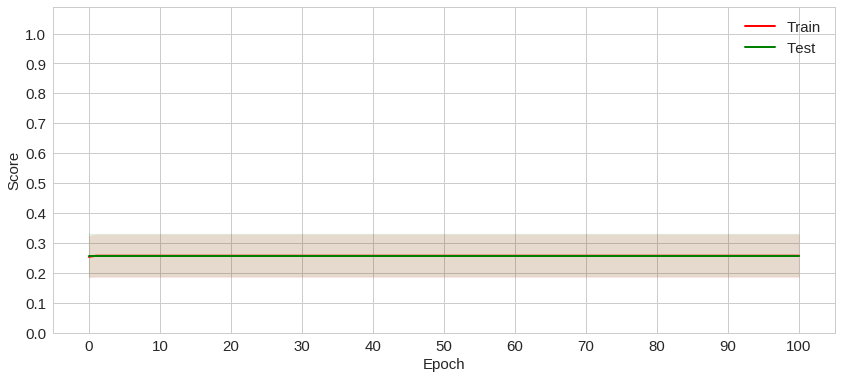

In [27]:
plot_mean_acc(hist)

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

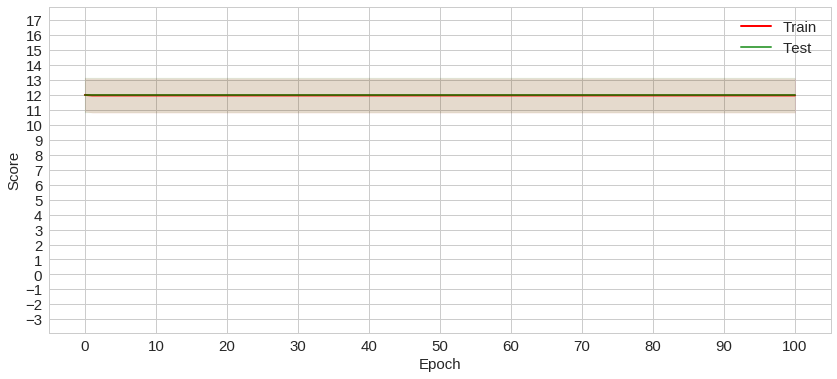

In [29]:
plot_mean_loss(hist)